# Beverages retail sales Forecasting

**Background** 

The dataset was provided by a large beverage company in Australia. They sell their products through various supermarkets and also engage into heavy promotions throughout the year. Their demand is also influenced by various factors like holiday, seasonality. They needed a forecast of each of the products (6 products in total) at item level every week in weekly buckets.

**Area of Investigation**

1. Trend
2. Seasonality
3. Serial dependence
4. Machine Learning on the time series data

## 1. Data Understanding and Preparation

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
import datetime

In [33]:
df = pd.read_csv('retail_data.csv')

In [34]:
df.shape

(1218, 12)

In [35]:
df.head()

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,SKU1,2/5/2017,27750,0%,0,0,0,0.0,0,0,0,0
1,SKU1,2/12/2017,29023,0%,1,0,1,0.0,0,1,0,0
2,SKU1,2/19/2017,45630,17%,0,0,0,0.0,0,0,0,0
3,SKU1,2/26/2017,26789,0%,1,0,1,0.0,0,0,0,0
4,SKU1,3/5/2017,41999,17%,0,0,0,0.0,0,0,0,0


### 1.1 Check data types

In [36]:
df.dtypes

Product                object
date                   object
Sales                   int64
Price Discount (%)     object
In-Store Promo          int64
Catalogue Promo         int64
Store End Promo         int64
Google_Mobility       float64
Covid_Flag              int64
V_DAY                   int64
EASTER                  int64
CHRISTMAS               int64
dtype: object

In [37]:
df['date'] = pd.to_datetime(df['date'])

In [38]:
df.dtypes

Product                       object
date                  datetime64[ns]
Sales                          int64
Price Discount (%)            object
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

In [39]:
df['Price Discount (%)'] = [x.replace('%', '') for x in df['Price Discount (%)']]
df['Price Discount (%)'] = df['Price Discount (%)'].astype('int64')

In [40]:
df.dtypes

Product                       object
date                  datetime64[ns]
Sales                          int64
Price Discount (%)             int64
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

All data types are correct

### 1.2 Check missing values

In [41]:
df.apply(lambda x: sum(x.isnull()),axis=0)

Product               0
date                  0
Sales                 0
Price Discount (%)    0
In-Store Promo        0
Catalogue Promo       0
Store End Promo       0
Google_Mobility       0
Covid_Flag            0
V_DAY                 0
EASTER                0
CHRISTMAS             0
dtype: int64

No missing values were found

### 1.3 Rename the columns

In [42]:
df.columns = [c.replace(' ', '_') for c in df.columns]
df = df.rename(columns = {'In-Store_Promo' : 'In_Store_Promo'})
df.columns

Index(['Product', 'date', 'Sales', 'Price_Discount_(%)', 'In_Store_Promo',
       'Catalogue_Promo', 'Store_End_Promo', 'Google_Mobility', 'Covid_Flag',
       'V_DAY', 'EASTER', 'CHRISTMAS'],
      dtype='object')

### 1.4 Check for outliers

<Axes: xlabel='Sales', ylabel='Product'>

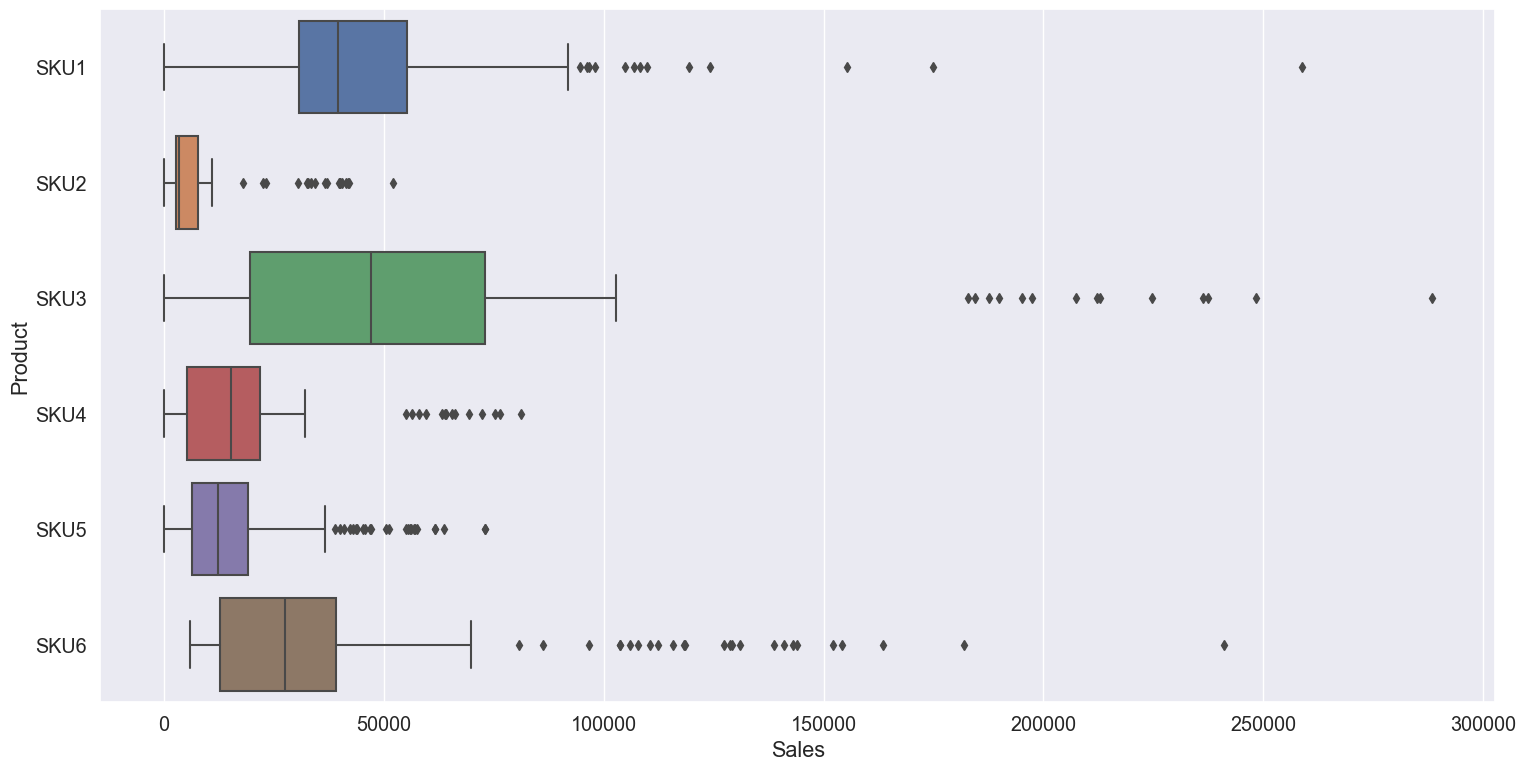

In [43]:
plt.figure(figsize=(18,9))
sns.set(font_scale = 1.3)
sns.boxplot(data = df, y = 'Product', x = "Sales", dodge=False)

According to the graphs, there are products with `Sales` equals to zero. It is believed that the testing data is mixed into the data set after checking the data.

In [44]:
# remove the 0 Sales
df = df.drop(df[df.Sales == 0].index)

<Axes: xlabel='Sales', ylabel='Product'>

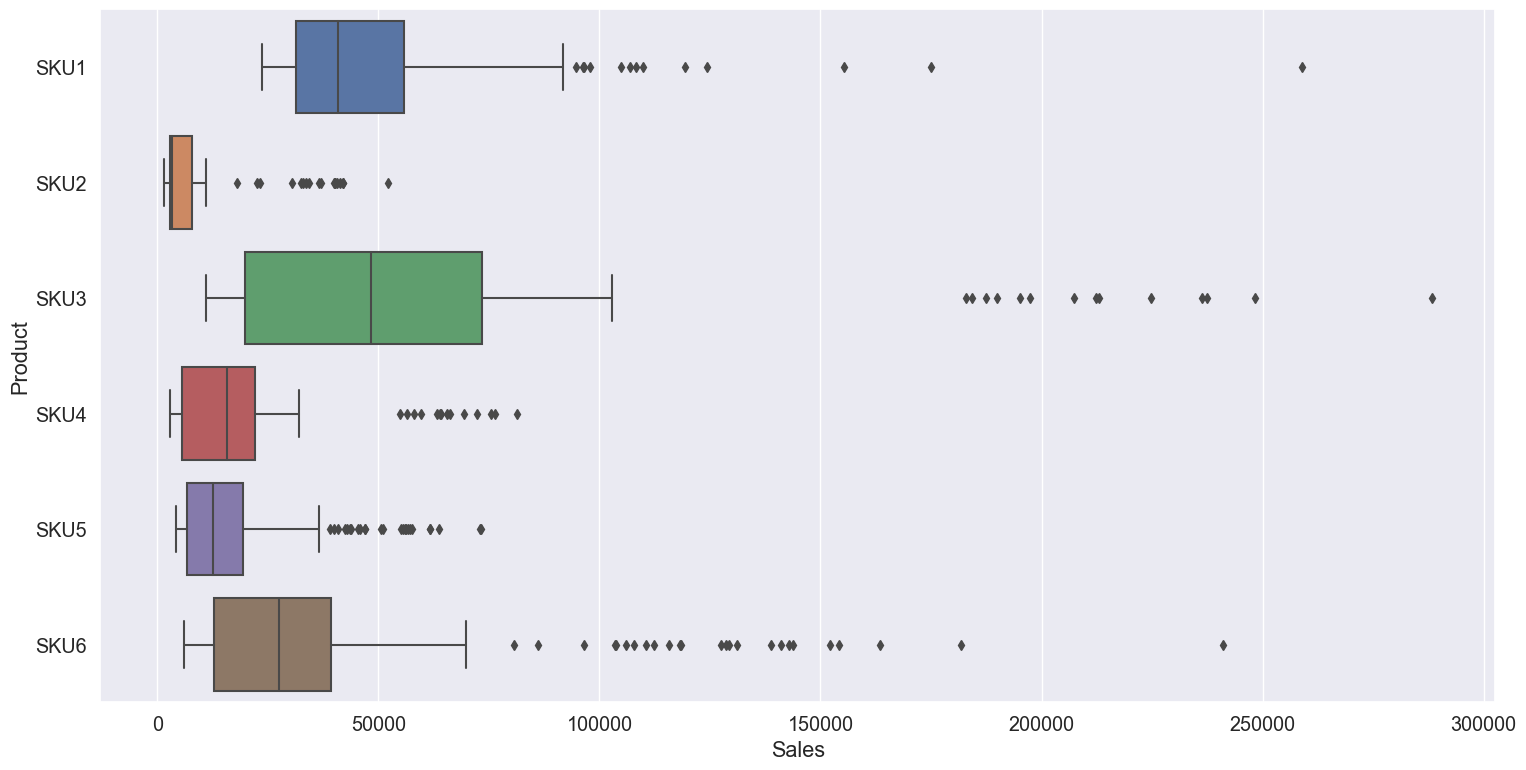

In [45]:
plt.figure(figsize=(18,9))
sns.set(font_scale = 1.3)
sns.boxplot(data = df, y = 'Product', x = "Sales", dodge=False)

After removing the `Sales` equal to zero, there are still some outliers in the `Sales` feature. But since we do not have enough information on the components for the sales, it is not appropriate to treat it as an outlier.

## 2. Exploratory Data Analysis

### 2.1 Data description

In [46]:
round(df.describe(),2)

,date,Sales,Price_Discount_(%),In_Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
count,1188,1188.00,1188.00,1188.00,1188.00,1188.00,1188.00,1188.00,1188.00,1188.00,1188.00
mean,2018-12-26 12:00:00,31059.70,24.71,0.47,0.21,0.35,-2.28,0.21,0.02,0.02,0.02
min,2017-02-05 00:00:00,1453.00,0.00,0.00,0.00,0.00,-28.49,0.00,0.00,0.00,0.00
25%,2018-01-14 00:00:00,7695.25,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2018-12-26 12:00:00,20547.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2019-12-08 00:00:00,40978.00,40.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
max,2020-11-15 00:00:00,288322.00,83.00,1.00,1.00,1.00,3.90,1.00,1.00,1.00,1.00
std,NaN,35135.66,21.32,0.50,0.41,0.48,5.84,0.41,0.14,0.14,0.12


### 2.2 Data visualisation

In [47]:
df = df.set_index('date')

In [48]:
df['Product'].unique()

array(['SKU1', 'SKU2', 'SKU3', 'SKU4', 'SKU5', 'SKU6'], dtype=object)

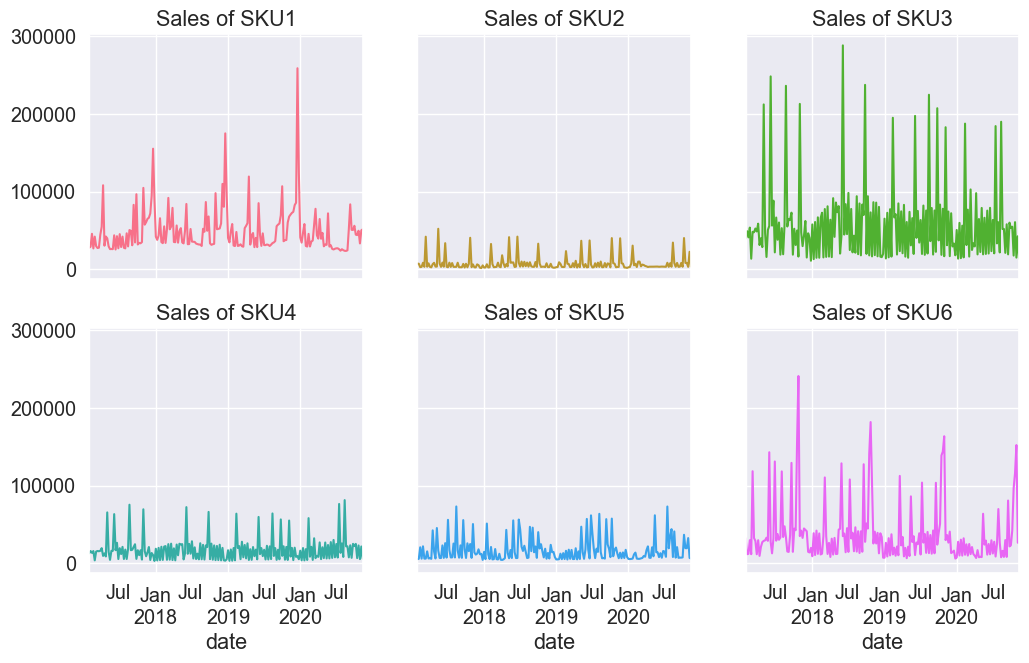

In [49]:
fig, ax = plt.subplots(2, 3, figsize = (12, 7), sharex = True, sharey = True)
palette = sns.color_palette("husl", n_colors=df['Product'].nunique())

for i, c in enumerate(palette):
    product_name = f"SKU{str(i+1)}"
    df.query('Product == @product_name') \
        .Sales \
        .plot(ax = ax[i // 3][i % 3], color = c, title = f"Sales of {product_name}")
    


### 2.3 Correlation

In [50]:
df_corr = df.corr(numeric_only=True)
df_corr

,Sales,Price_Discount_(%),In_Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
Sales,1.000000,0.432887,0.252071,-0.124398,0.234811,0.044885,-0.047748,-0.011653,-0.013495,-0.013893
Price_Discount_(%),0.432887,1.000000,0.225429,-0.091492,0.234464,-0.207491,0.265120,-0.042953,0.003640,-0.035163
In_Store_Promo,0.252071,0.225429,1.000000,-0.488728,0.367410,0.060471,-0.038873,0.020951,0.020951,0.021550
Catalogue_Promo,-0.124398,-0.091492,-0.488728,1.000000,0.124778,0.075202,-0.098381,-0.045466,-0.045466,0.036468
Store_End_Promo,0.234811,0.234464,0.367410,0.124778,1.000000,0.082501,-0.067667,0.019489,-0.068211,0.009620
Google_Mobility,0.044885,-0.207491,0.060471,0.075202,0.082501,1.000000,-0.764376,0.076392,-0.111869,0.048450
Covid_Flag,-0.047748,0.265120,-0.038873,-0.098381,-0.067667,-0.764376,1.000000,0.015213,0.015213,-0.063385
V_DAY,-0.011653,-0.042953,0.020951,-0.045466,0.019489,0.076392,0.015213,1.000000,-0.020619,-0.017810
EASTER,-0.013495,0.003640,0.020951,-0.045466,-0.068211,-0.111869,0.015213,-0.020619,1.000000,-0.017810
CHRISTMAS,-0.013893,-0.035163,0.021550,0.036468,0.009620,0.048450,-0.063385,-0.017810,-0.017810,1.000000


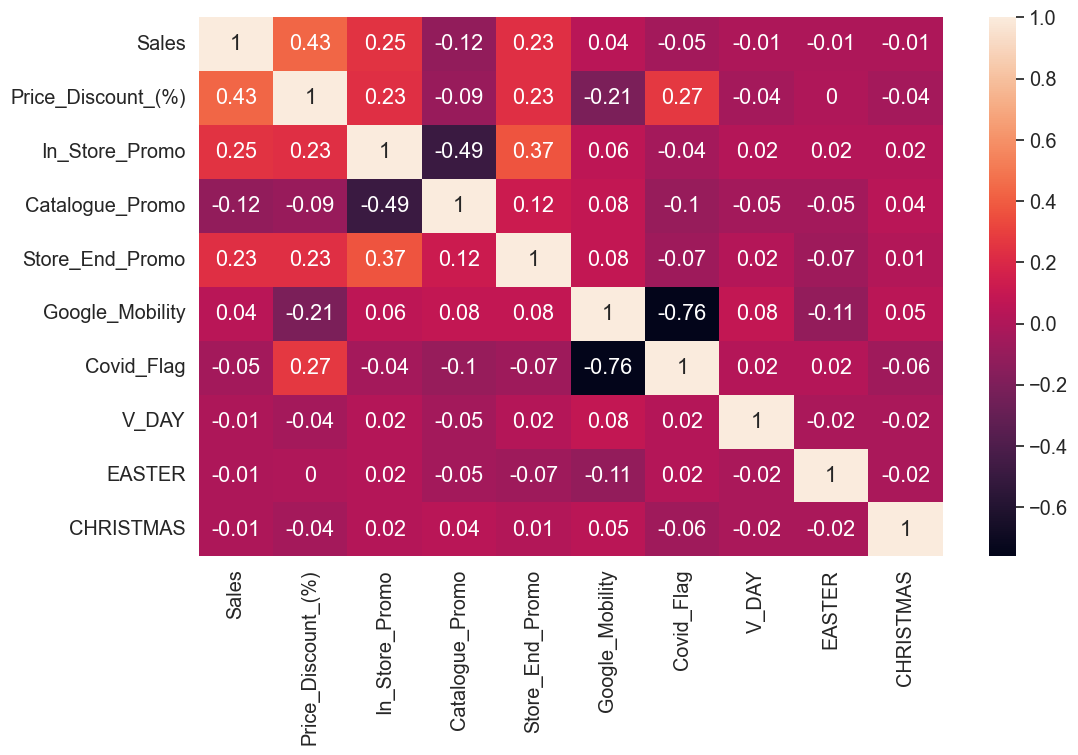

In [51]:
fig, ax = plt.subplots(figsize = (12, 7))
ax = sns.heatmap(data = round(df_corr, 2),
           annot =True)

From the heatmap, we see that `Google_Mobility` has an inverse correlation with `Covid_Flag`. `In_Store_Promo` is slightly correlated with `Catalogue_Promo` and also for `Sales` and `Price_Discount_(%)`. 

## 3. Features engineering

### 3.1 Recreate dataframe with products name

In [52]:
df_group = df.reset_index().groupby('Product')
# sku1 = df_group.get_group("SKU1")
# sku2 = df_group.get_group("SKU2")
# sku3 = df_group.get_group("SKU3")
# sku4 = df_group.get_group("SKU4")
# sku5 = df_group.get_group("SKU5")
# sku6 = df_group.get_group("SKU6")

skus = {'sku1' : df_group.get_group("SKU1"),
    'sku2' : df_group.get_group("SKU2"),
    'sku3' : df_group.get_group("SKU3"),
    'sku4' : df_group.get_group("SKU4"),
    'sku5' : df_group.get_group("SKU5"),
    'sku6' : df_group.get_group("SKU6")}

In [53]:
for key, datf in skus.items():
    print(f"{key.upper()}\'s dataset shape: {datf.shape}")

SKU1's dataset shape: (198, 12)
SKU2's dataset shape: (198, 12)
SKU3's dataset shape: (198, 12)
SKU4's dataset shape: (198, 12)
SKU5's dataset shape: (198, 12)
SKU6's dataset shape: (198, 12)


### 3.1 Detect the trend and seasonality of the series

In [83]:
# graphs to show seasonal_decompose
def seasonal_decompose (y, title):
    y = y.rename(title)
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

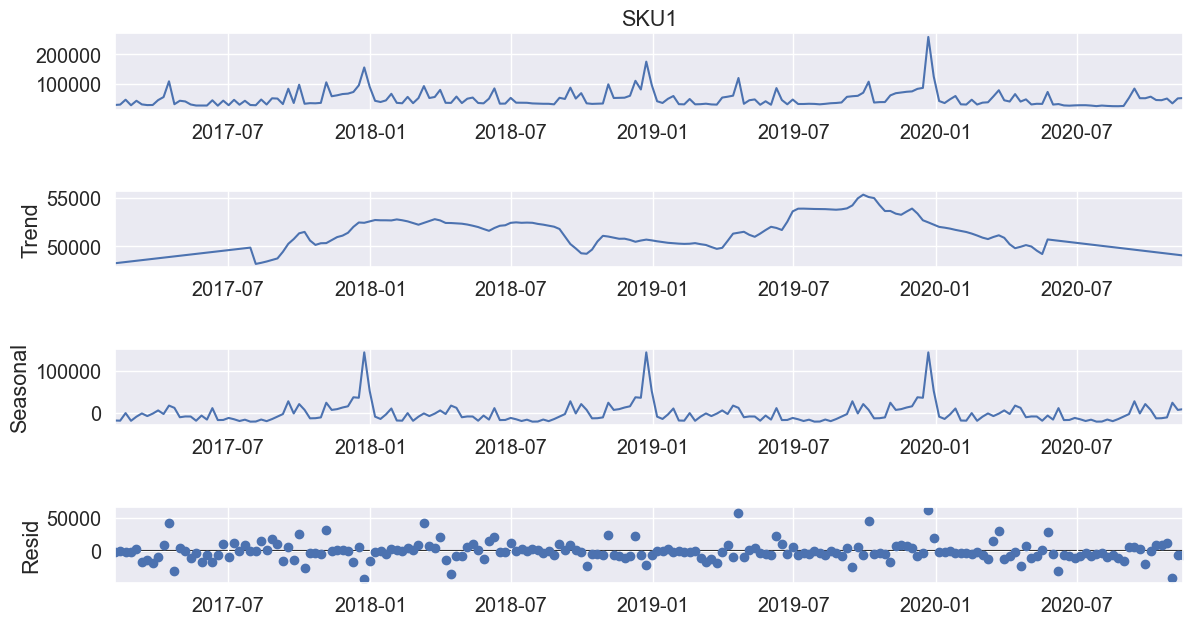

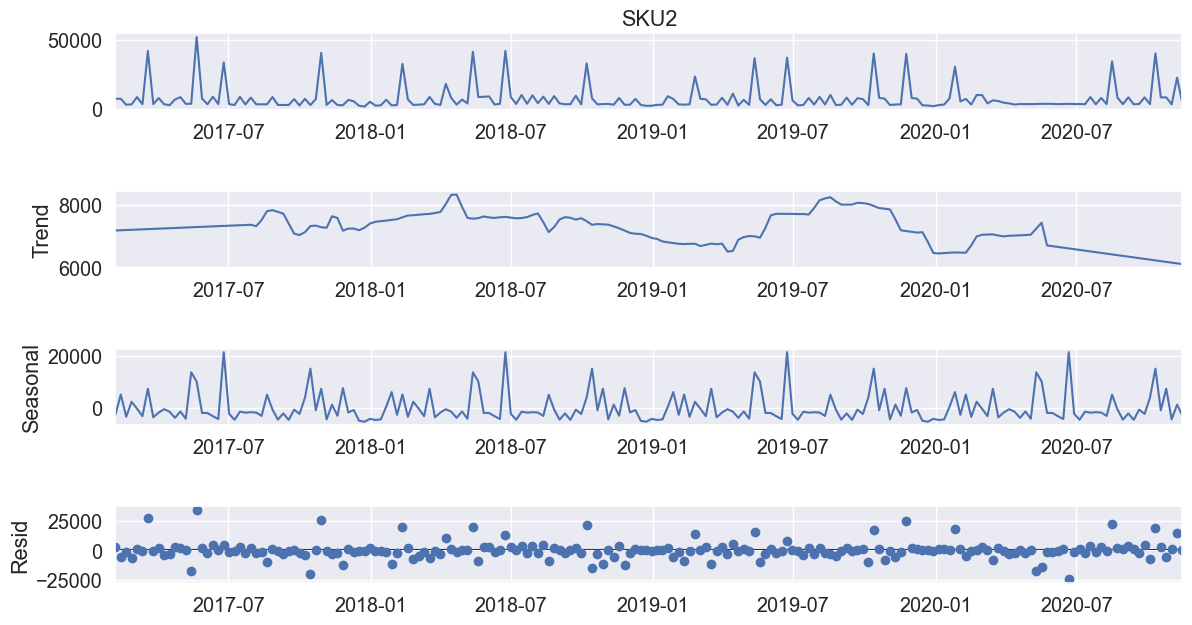

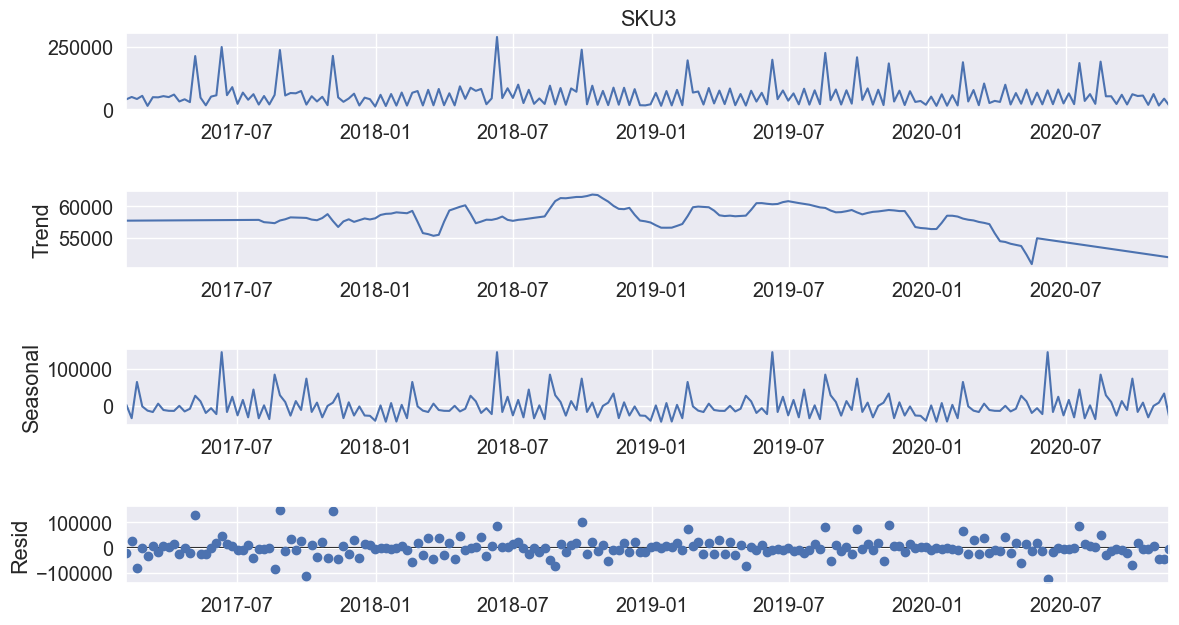

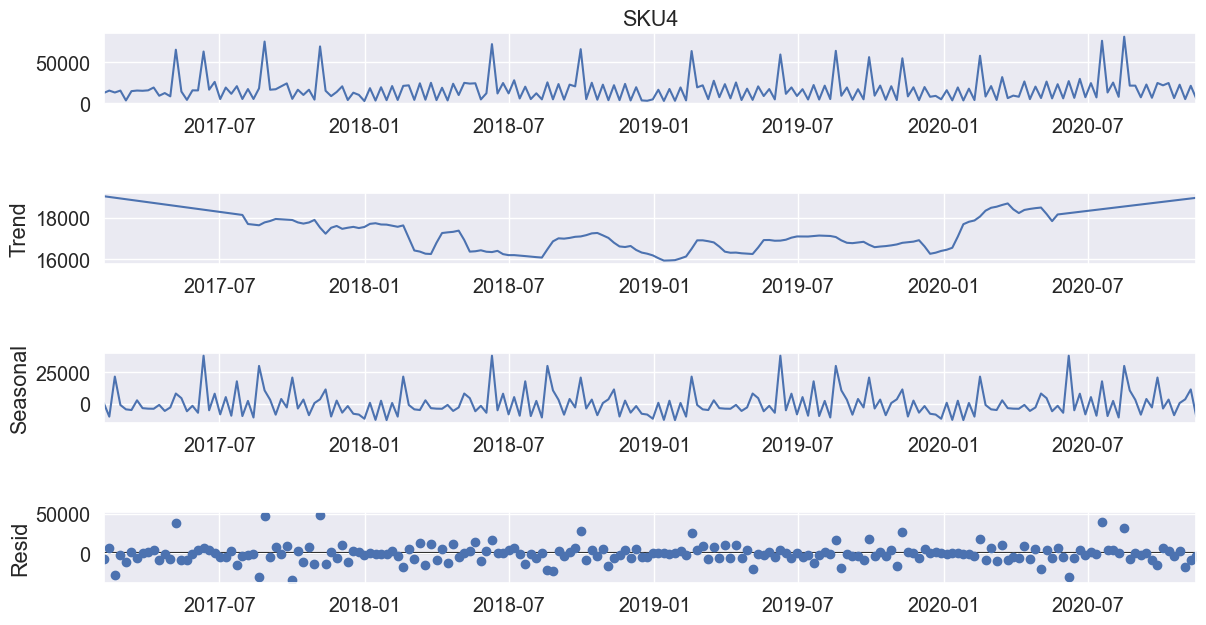

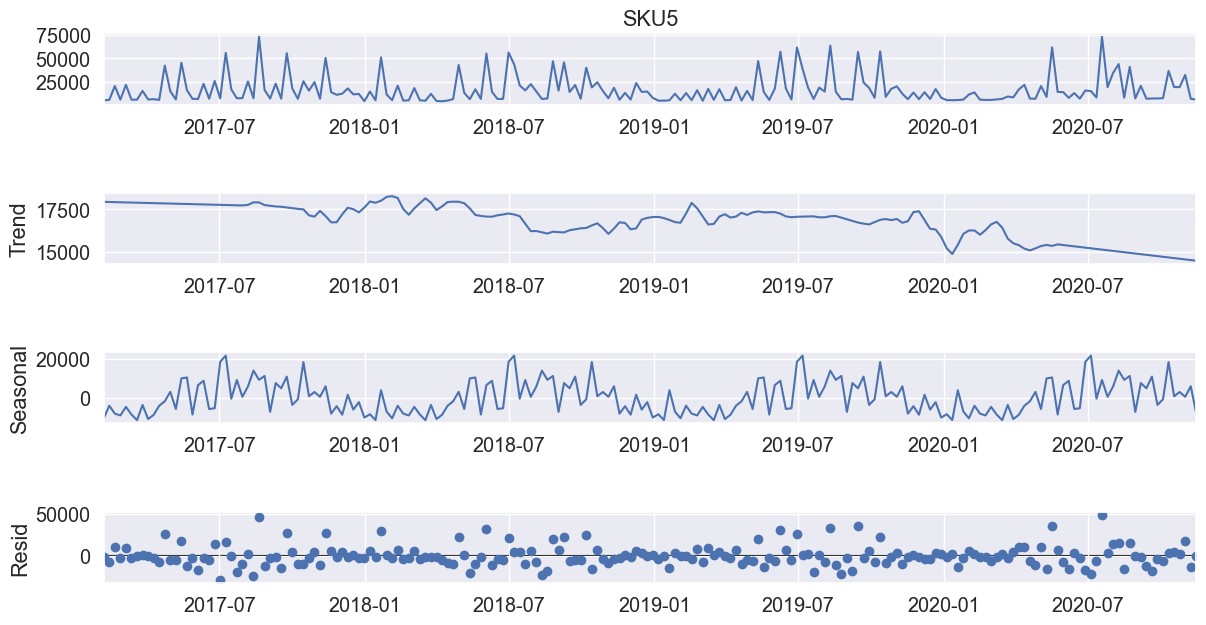

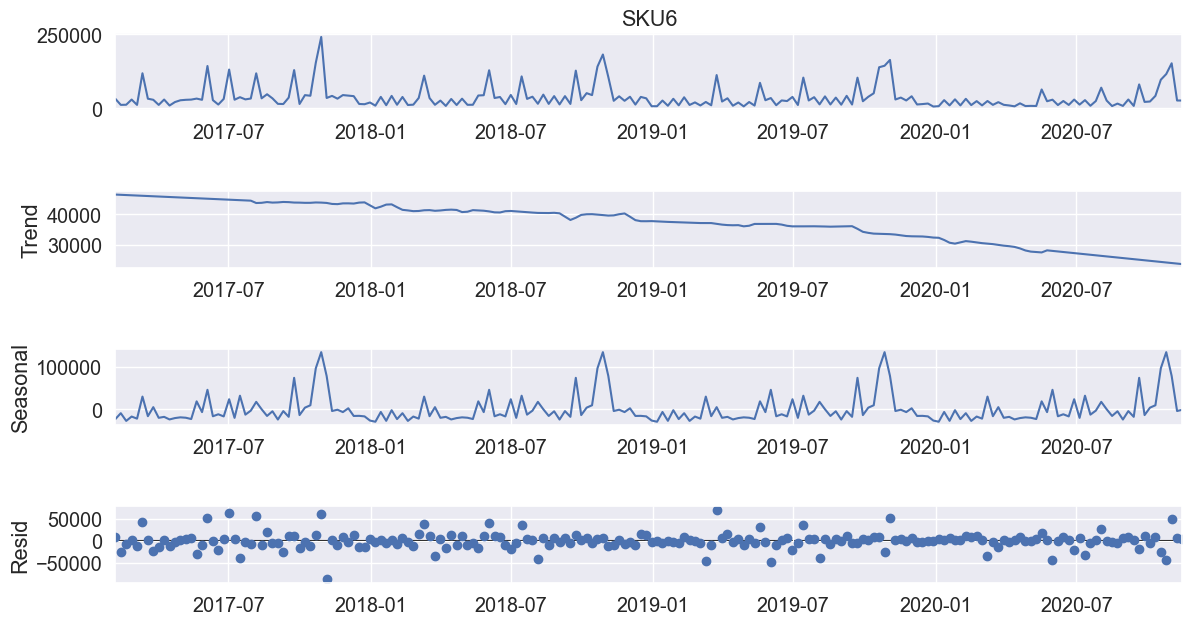

In [89]:
for key, sku in skus.items():
    sku = sku.set_index('date')
    seasonal_decompose(sku.Sales, key.upper())

In [55]:


sku1 = skus['sku1'].set_index('date')

dp = DeterministicProcess(index = sku1.index,
                         constant = True,
                         order = 1,
                         drop = True)

X = dp.in_sample()



y = sku1['Sales']  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

y_pred.head()

date
2017-02-05    48335.239633
2017-02-12    48341.602272
2017-02-19    48347.964911
2017-02-26    48354.327550
2017-03-05    48360.690189
dtype: float64

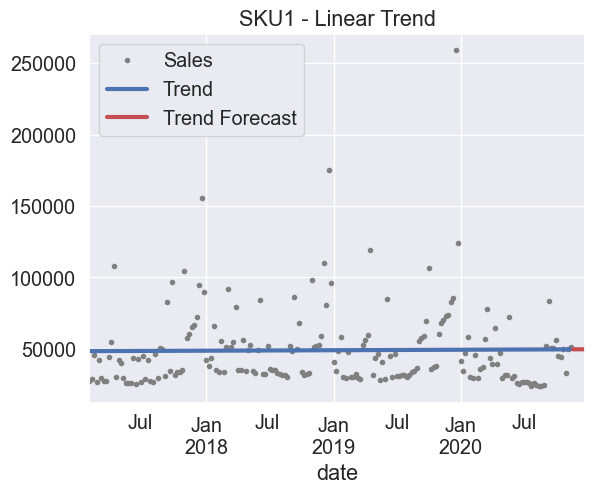

In [56]:
# import warnings
# warnings.filterwarnings("ignore")


X = dp.out_of_sample(steps=6)
d = [datetime.datetime(2020, 11, 22), datetime.datetime(2020, 11, 29),
     datetime.datetime(2020, 12, 6), datetime.datetime(2020, 12, 13),
    datetime.datetime(2020, 12, 20), datetime.datetime(2020, 12, 27)]

y_fore = pd.Series(model.predict(X), index=d)

y_fore.head()

ax = sku1.Sales.plot(style=".", color="0.5", title="SKU1 - Linear Trend")
y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
ax.legend()

### 3.2 Seasonality

In [57]:
# function to plot the seasonal plot
def seasonal_plot(X, y, period, freq, ax=None):
    if not ax:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [64]:
# function to plot periodogram
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("52D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if not ax:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            
          ],
        rotation=90,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

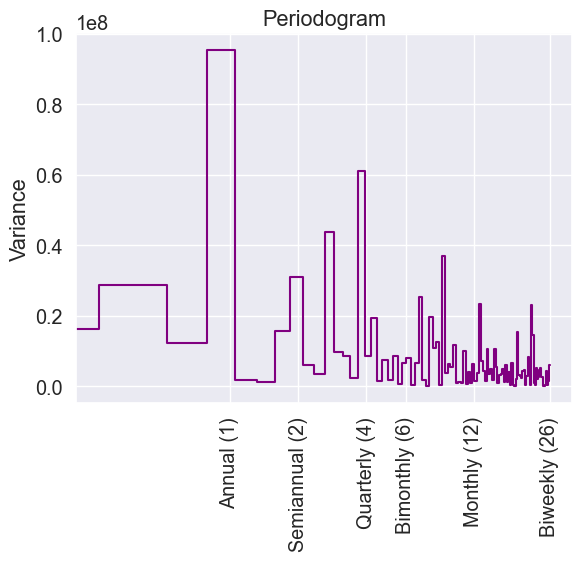

In [65]:
plot_periodogram(sku1.Sales);

In [72]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

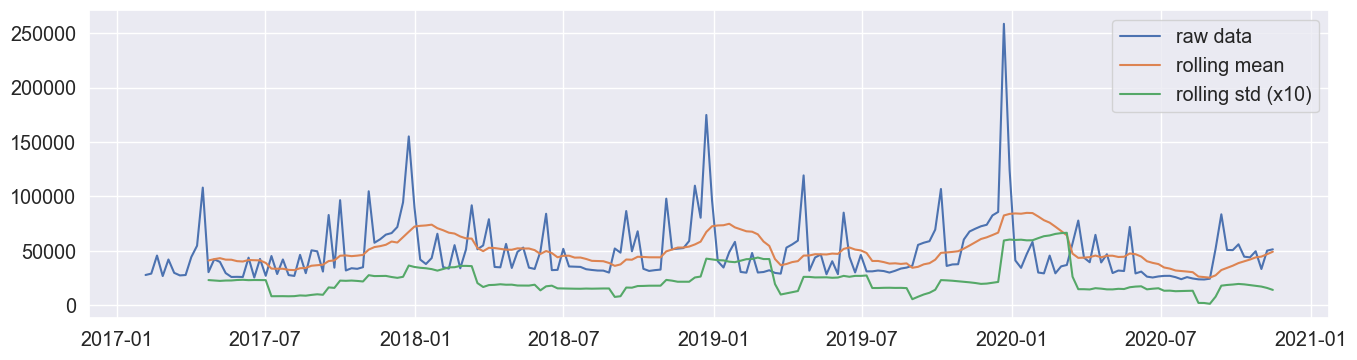

In [73]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(sku1.Sales,'raw data')

In [74]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [75]:
ADF_test(sku1.Sales,'raw data')

 > Is the raw data stationary ?
Test statistic = -9.083
P-value = 0.000
Critical values :
	1%: -3.463987334463603 - The data is  stationary with 99% confidence
	5%: -2.8763259091636213 - The data is  stationary with 95% confidence
	10%: -2.5746515171738515 - The data is  stationary with 90% confidence


 > Is the de-trended data stationary ?
Test statistic = -5.469
P-value = 0.000
Critical values :
	1%: -3.4674201432469816 - The data is  stationary with 99% confidence
	5%: -2.877826051844538 - The data is  stationary with 95% confidence
	10%: -2.575452082332012 - The data is  stationary with 90% confidence


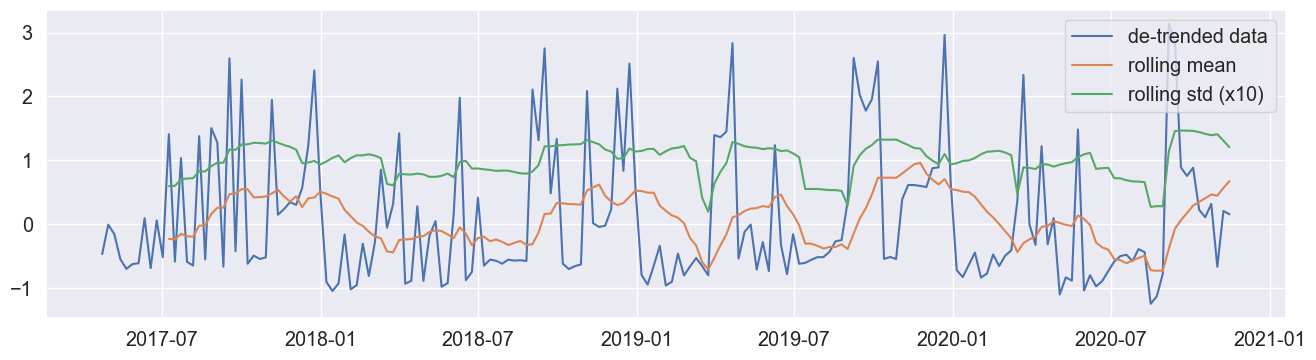